In [ ]:
%matplotlib inline
from IPython.display import display, Markdown
from datetime import time, datetime, date, timedelta
import snakemd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import fitfile
from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminDb, Attributes, ActivitiesDb, Activities, StepsActivities, ActivityLaps, ActivityRecords
from idbutils.list_and_dict import list_not_none

from jupyter_funcs import format_number

gc_config = GarminConnectConfigManager()
db_params_dict = gc_config.get_db_params()

garmin_db = GarminDb(db_params_dict)
garmin_act_db = ActivitiesDb(db_params_dict)
measurement_system = Attributes.measurements_type(garmin_db)
unit_strings = fitfile.units.unit_strings[measurement_system]
distance_units = {"kilometers": "km"}[unit_strings[fitfile.units.UnitTypes.distance_long]]

def __format_activity(activity):
    if activity:
        if activity.is_steps_activity():
            steps_activity = StepsActivities.get(garmin_act_db, activity.activity_id)
            return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, activity.moving_time, format_number(activity.avg_speed, 1), format_number(activity.calories)]
        return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, activity.moving_time, format_number(activity.avg_speed, 1), format_number(activity.calories)]
    return ['', '', '', '', '', '', '', '', '']


activities = Activities.get_latest(garmin_act_db, Activities.row_count(garmin_act_db))

In [29]:
def debug(name=None):
    doc = snakemd.new_doc()
    if (name is None):
        rows = [__format_activity(activity) for activity in activities]
    else:
        rows = [__format_activity(activity) for activity in activities if ((activity.name is not None) and (name in activity.name.lower()))]
    doc.add_heading("All Recorded Activities", 3)
    doc.add_table(['Id', 'Name', 'Date', 'Sport', f'Dist ({distance_units})', 'Elapsed Time', f'Moving Time', f'Speed ({unit_strings[fitfile.units.UnitTypes.speed]})', 'Calories'], rows)
    display(Markdown(str(doc)))

In [30]:
import numpy as np

def __plot_activity(name:str, ydata:str, cdata:str, ylimdata = None, yticksdata:tuple[float, float] = None):
    start_dates = []
    moving_times = []
    moving_times_min = []
    distances = []
    calories = []
    time100m = []
    time1000m = []
    speed = []
    for activity in activities:
        if ((activity.name is not None) and (name in activity.name.lower())):
            s = activity.distance
            t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds()
            if (s > 0):
                time100m += [t/s/10]
                time1000m += [t/s]
            else:
                time100m += [0]
                time1000m += [0]
            start_dates += [activity.start_time]
            moving_times += [t]
            moving_times_min += [t/60]
            calories += [activity.calories]
            distances += [s]
            speed += [activity.avg_speed]

    yarray = []
    carray = []
    match ydata:
        case "moving_time": yarray = moving_times
        case "moving_time_min": yarray = moving_times_min
        case "calorie": yarray = calories
        case "distance": yarray = distances
        case "time100m": yarray = time100m
        case "time1000m": yarray = time1000m
        case "speed": yarray = speed
    match cdata:
        case "moving_time": carray = moving_times
        case "moving_time_min": carray = moving_times_min
        case "calorie": carray = calories
        case "distance": carray = distances
        case "time100m": carray = time100m
        case "time1000m": carray = time1000m
        case "speed": carray = speed

    fig = plt.figure(figsize=(20,5), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(start_dates, yarray, c=carray, norm=matplotlib.colors.LogNorm(), cmap="rainbow")

    x_num = dates.date2num(start_dates)
    trend = np.polyfit(x_num, yarray, 4)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

    ax = plt.gca()
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    years = plt.matplotlib.dates.YearLocator()
    months = plt.matplotlib.dates.MonthLocator()
    # yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(months)
    # ax.xaxis.set_major_formatter(yearsFmt)

    plt.title(f"{ydata} across {len(start_dates)} {name} sessions")
    plt.colorbar(label=cdata)
    plt.ylabel(ydata)
    if ylimdata is not None:
        plt.ylim(ylimdata)
    if yticksdata is not None:
        plt.yticks(yticksdata)
    plt.show()


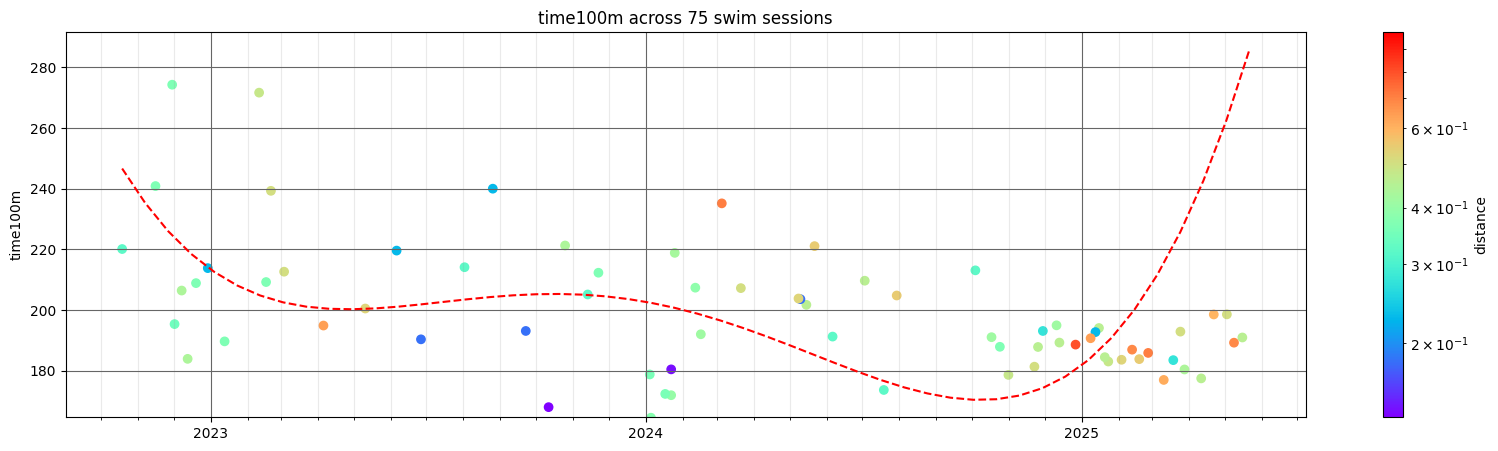

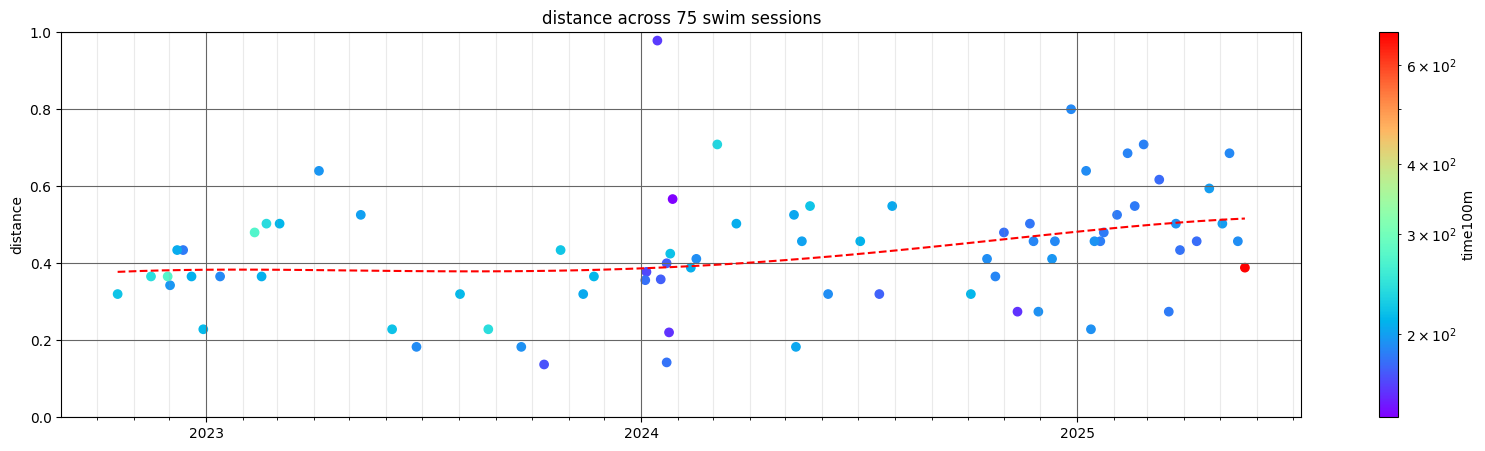

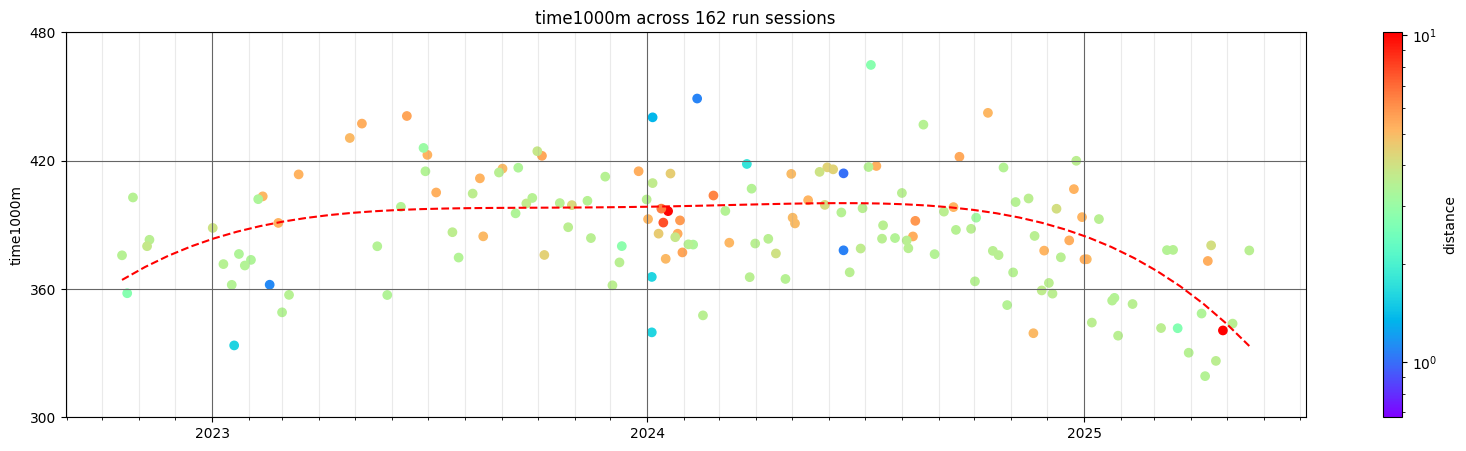

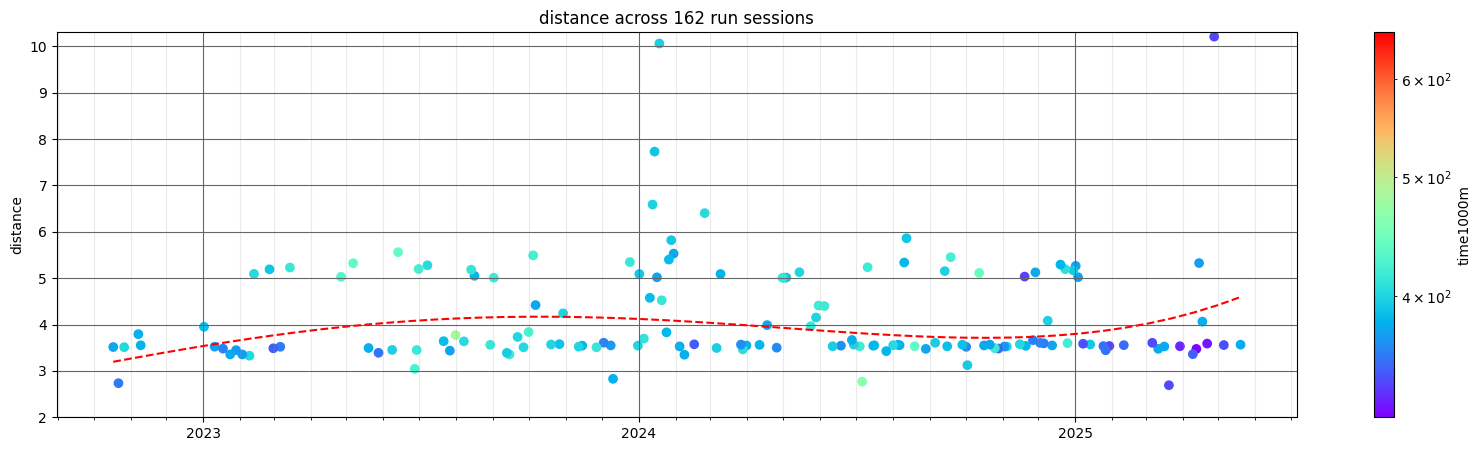

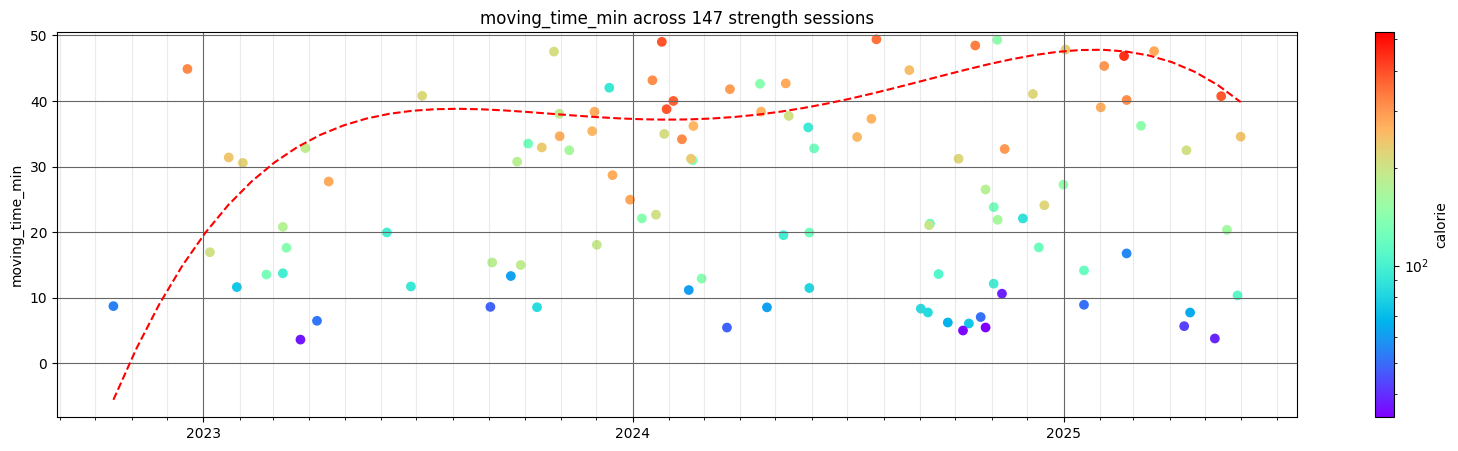

In [35]:
__plot_activity("swim", "time100m", "distance")
__plot_activity("swim", "distance", "time100m", ylimdata=[0, 1])
__plot_activity("run", "time1000m", "distance", yticksdata=[300, 360, 420, 480], ylimdata=[300, 480])
__plot_activity("run", "distance", "time1000m", ylimdata=[2, 10.3])
__plot_activity("strength", "moving_time_min", "calorie")
